In [37]:
# Imports 
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
# import Sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import sklearn RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# Import MAE
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from pmdarima.arima import ndiffs, nsdiffs 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [38]:
# Load data
df_prod = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-PROD.csv")
df_cons = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-CONS.csv")

df_prod_2_year_cons = pd.read_csv('data/year_coverage_consumption_100.csv')
df_prod_2_year_prod = pd.read_csv('data/year_coverage_production_100.csv')

df_prod_2_year_prod = df_prod_2_year_prod[df_prod_2_year_prod["time_between_first_last"] >= 2]
df_prod_2_year_cons = df_prod_2_year_cons[df_prod_2_year_cons["time_between_first_last"] >= 2]

# Sort by time_between_first_last
df_prod_2_year_cons = df_prod_2_year_cons.sort_values(by=['time_between_first_last'], ascending=False)
df_prod_2_year_prod = df_prod_2_year_prod.sort_values(by=['time_between_first_last'], ascending=False)

In [39]:
#Series stuff
def get_series(meter_id, type="prod", start=None, end=None, agg=None):
    """Create Series from meter_id and type of data

    Args:
        meter_id (str): meter-id
        type (str, optional): production or consumption of kwh. Defaults to "prod".
        start (str, optional): timeslot to start series. Defaults to None.
        end (str, optional): timeslot to end series. Defaults to None.
        agg (str, optional): aggregation of data. One of day, week or month. Defaults to None.

    Returns:
        pd.series: series of filtered data
    """

    print("Getting series for meter_id: {}".format(meter_id))

    # if start not none
    if start is not None:
        # Convert to datetime
        start = pd.to_datetime(start)
    
    # if end not none
    if end is not None:
        # Convert to datetime
        end = pd.to_datetime(end)

    if type == "prod":
        df_return = df_prod[df_prod["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh_normalized']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    elif type == "cons":
        df_return = df_cons[df_cons["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh_normalized']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    df_return = df_return.set_index("timeslot").sort_index()

    # If agg is not none
    if agg is not None:
        if agg == "day":
            df_return = df_return.resample("D").sum()
        elif agg == "week":
            df_return = df_return.resample("W").sum()
        elif agg == "month":
            df_return = df_return.resample("M").sum()
        else:
            print("Aggregation not supported")
            return None

    # Return series
    return df_return

In [40]:
# Cut data to only use the first year
series = get_series("28ba7f57-6e83-4341-8078-232c1639e4e3",
                        type="prod",
                        start=None,
                        end=None,
                        agg="day")
print(series.head(10))

Getting series for meter_id: 28ba7f57-6e83-4341-8078-232c1639e4e3
                           num_kwh_normalized
timeslot                                     
2016-09-04 00:00:00+00:00            0.000000
2016-09-05 00:00:00+00:00            0.638889
2016-09-06 00:00:00+00:00            0.083333
2016-09-07 00:00:00+00:00            0.500000
2016-09-08 00:00:00+00:00            0.361111
2016-09-09 00:00:00+00:00            0.000000
2016-09-10 00:00:00+00:00            0.000000
2016-09-11 00:00:00+00:00            0.027778
2016-09-12 00:00:00+00:00            0.416667
2016-09-13 00:00:00+00:00            0.277778


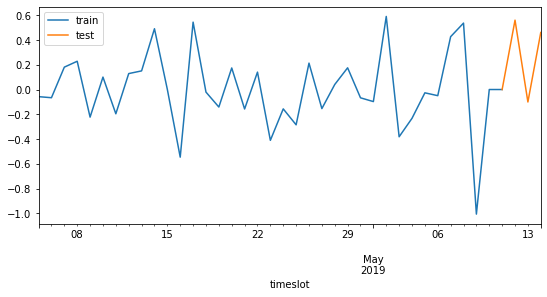

In [63]:
units_to_forecast = 4

train = train_series[:-units_to_forecast]
test = train_series[-units_to_forecast:]
actual = train_series[-units_to_forecast*10:-units_to_forecast+1]


fig, ax=plt.subplots(figsize=(9, 4))
actual['num_kwh_normalized'].plot(ax=ax, label='train')
test['num_kwh_normalized'].plot(ax=ax, label='test')
ax.legend();

In [60]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=train['num_kwh_normalized'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-09-05 00:00:00+0000', tz='UTC'), Timestamp('2019-05-10 00:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-07 15:45:56 
Last fit date: 2022-06-07 15:45:57 
Skforecast version: 0.4.3 

Test error (mse): 0.1818734938561341


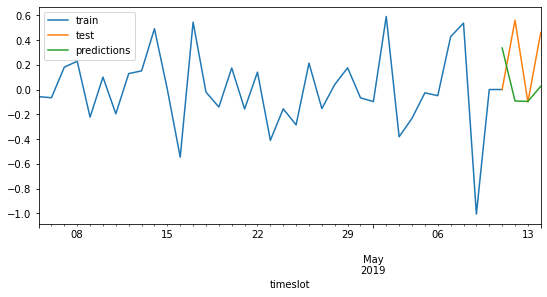

In [64]:
predictions = forecaster.predict(steps=units_to_forecast)
predictions.head(5)

fig, ax = plt.subplots(figsize=(9, 4))
actual['num_kwh_normalized'].plot(ax=ax, label='train')
test['num_kwh_normalized'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

error_mse = mean_squared_error(
                y_true = test['num_kwh_normalized'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

# Hyperparameter tuning

In [57]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [i for i in range(10,200,10)]

# Regressor's hyperparameters
param_grid = {'n_estimators': [i for i in range(50,300,10)],
              'max_depth': [i for i in range(3,5,1)]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['num_kwh_normalized'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = units_to_forecast,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 950


loop param_grid:   0%|                                             | 0/50 [00:00<?, ?it/s]

Forecaster will be fit 123 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:   2%|▋                                    | 1/50 [00:25<20:38, 25.28s/it]

Forecaster will be fit 123 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:   4%|█▍                                   | 2/50 [00:51<20:38, 25.80s/it]

Forecaster will be fit 123 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:   6%|██▏                                  | 3/50 [01:20<21:14, 27.12s/it]

Forecaster will be fit 123 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:   8%|██▉                                  | 4/50 [01:50<21:52, 28.53s/it]

Forecaster will be fit 123 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop lags_grid:   0%|                                              | 0/19 [02:19<?, ?it/s]


KeyboardInterrupt: 